In [0]:
import matplotlib.pyplot as plt
import random
!pip install trdg
from trdg.generators import GeneratorFromStrings  # used for generating text images for training 
import cv2
import numpy as np
import pickle
from PIL import Image
import os
import copy
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 49.9MB 60kB/s 
     |████████████████████████████████| 28.2MB 112kB/s 
  Created wheel for diffimg: filename=diffimg-0.2.3-cp36-none-any.whl size=4049 sha256=b971029fa12f51117f7a8dfbe62718ff714bb1de8730ab21e5187cf5d302276d
  Stored in directory: /root/.cache/pip/wheels/92/46/95/1de38a4ccb7811e6cc67fcc3594ea25180f85b70c406bdf0c3
Successfully built diffimg
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.losses import categorical_crossentropy 
from keras.utils import Sequence
import keras

Using TensorFlow backend.


In [0]:
# load lists with image information
with open('/content/drive/My Drive/SVT/train_images_.pickle', 'rb') as fp:
  train_images = pickle.load(fp)
with open('/content/drive/My Drive/SVT/val_images_.pickle', 'rb') as fp:
  valid_images = pickle.load(fp)
with open('/content/drive/My Drive/SVT/test_images_.pickle', 'rb') as fp:
  test_images = pickle.load(fp)

In [0]:
with open('/content/drive/My Drive/SVT/FINAL_LEXICON.pickle', 'rb') as fp:
  # load list of possible output words
  LEXICON = pickle.load(fp)
print(LEXICON)

['BLOOD', 'MICHAEL', 'FRANCIS', 'DELI', 'SHOCKS', 'BAMBOO', 'MATTHEW', 'CLIFT', 'ADY', 'WING', 'PARQUE', 'INVESTMENT', 'VERANDA', 'STAGE', 'HOODRIDE', 'PRIETO', 'EPICUREAN', 'KIDS', 'THORNTON', 'STEPHEN', 'HOFFMAN', 'MYSTERY', 'MEDICA', 'COLOMBINI', 'DISPUTE', 'AMBER', 'HIRSCH', 'ROCCO', 'MCSHANE', 'OBP', 'ANDREW', 'GIBNEYS', 'BLUE', 'MULTIMEDIA', 'AMOUR', 'ZOELLER', 'GENTLEMEN', 'SUBWAY', 'DIEGO', 'BOOKKEEPING', 'NORTHWEST', 'WALT', 'CALIFORNIA', 'PLAYGROUND', 'DAY', 'RUGBY', 'MINISTRY', 'PROFESIONALES', 'SIR', 'SECURITY', 'PHOTOGRAPHY', 'BERZIN', 'STUDIO', 'DEVELOPMENTAL', 'INTERIOR', 'THRU', 'WALL', 'BALTIMORE', 'MMSC', 'MEDITALIAN', 'KAN', 'PRESS', 'WORKFORCE', 'LEAVY', 'GHIOTTONE', 'BAM', 'PARKING', 'VANITY', 'ROCKET', 'GOLDEN', 'QUIZNOS', 'GENERATION', 'HIEP', 'ALCOHOLICOS', 'FLEXIBLE', 'GOAT', 'CLEANING', 'HUBER', 'PEN', 'SUPERIOR', 'ENCANA', 'GONZALEZ', 'BOWL', 'TEA', 'HKS', 'TABERNA', 'FELLOWSHIP', 'CHW', 'ZEKE', 'MENAMINS', 'MIDTOWN', 'RCA', 'VACATION', 'DREAMLAND', 'FURNITUR

In [0]:
# prepare final list of words to be fed into GeneratorFromStrings to generate images  
caps = LEXICON *4
titles = [ele.title() for ele in caps]
list_concat = []
list_concat.append(caps)
list_concat.append(titles)
NEW_LEX = [item for sublist in list_concat for item in sublist]
print(len(NEW_LEX)) # GLOBAL
print(NEW_LEX[:5])

42904
['BLOOD', 'MICHAEL', 'FRANCIS', 'DELI', 'SHOCKS']


In [0]:
######## DOWNLOAD AND USE GOOGLE FONTS TO IMPROVE RESULTS, not used due to memory issues ########

# download google fonts from https://github.com/google/fonts/archive/master.zip

# def getfonts(dirname):
#   # dirname - directory where the fonts directories are stored
#   path = os.path.join('/content/drive/My Drive/SVT',dirname)
#   fontnames = []
#   for font in os.listdir(path):
#     fontnames.append(font)
#   return fontnames

# FONTNAMES = getfonts('ofl')  #GLOBAL
# random.shuffle(FONTNAMES)
# FINALFONTS = FONTNAMES[:100]

# def get_random_font(dirname):
#   # dirname - directory where the fonts directories are stored
#   path = os.path.join('/content/drive/My Drive/SVT', dirname)

#   inp = random.choice(FINALFONTS)
#   result = [each for each in os.listdir(os.path.join(path, inp)) if each.endswith('.ttf')]
#   fname = random.choice(result)
#   fonts = [os.path.join(os.path.join(path, inp), fname)]
#   return fonts

In [0]:
class TrainBatchGenerator(Sequence):
  # Batch Generator which outputs x_batch(images), y_batch(labels)

  def __init__(self, image_wordlist, label_wordlist, config, shuffle = True):
    
    self.config = config  # dictionary with relevant image information 
    self.wordlist = image_wordlist.copy()  #  lexicon to be used for image (x) generation
    self.ylist = label_wordlist.copy()  # lexicon to be used for label (y) generation
    self.num_classes = len(self.ylist) # number of labels (to be incrementally increased)
    self.shuffle = shuffle

  def __len__(self):
    # denotes number of batches per epoch
    return int(np.ceil(float(len(self.wordlist)) / self.config['BATCH_SIZE']))

  def on_epoch_end(self):
    # shuffle at end of epoch for variability
    if self.shuffle:
      random.shuffle(self.wordlist)

  def preprocess(self, image, invert_colours = False):
    # preprocess image-
    img = np.asarray(image).astype('float32')
    img = cv2.resize(img, (self.config['IMAGE_W'], self.config['IMAGE_H']))
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    maxIntensity = 255.0 
    phi = 1
    theta = 1

    if invert_colours:# if black background, white text
      img = 255 - img
      img = (maxIntensity/phi)*(img/(maxIntensity/theta))**0.5
    else:
      img = (maxIntensity/phi)*(img/(maxIntensity/theta))**2

    img =img.astype('float32')
    mean, std = cv2.meanStdDev(img)
    img = (img-mean)/std
    img = img.reshape((self.config['IMAGE_H'], self.config['IMAGE_W'], self.config['N_C']))
    return img

  def __getitem__(self, idx):
    # to find the left and right bounds for x_batch and y_batch creation
    l_bound = idx * self.config['BATCH_SIZE']
    r_bound = (idx + 1) * self.config['BATCH_SIZE']
    if r_bound > len(self.wordlist):
      r_bound = len(self.wordlist)
      l_bound = r_bound - self.config['BATCH_SIZE']

    use_list = self.wordlist[l_bound:r_bound].copy()  #slice wordlist to generate img, lbl

    x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], self.config['N_C']))
    y_batch = np.zeros((r_bound - l_bound, self.num_classes)) 

    instance_count = 0

    for element in use_list:
      # generate images with different distortion, skew and backgrounds
      mygenerator = GeneratorFromStrings([element], count = 1, text_color = '#000000', background_type = random.choice([0,1]),
                           distorsion_type=random.choice([0,1]), distorsion_orientation= random.choice([0,1]),
                           skewing_angle = random.randint(354,366),margins = (2,2,2,2), fit = True)
      
      for img, lbl in mygenerator:  # iterating over 1 image, label pair only
        img = self.preprocess(img, random.choice([True, False]))
        x_batch[instance_count] = img 

        if lbl.upper() in self.ylist: # .upper() as LEXICON (list of labels) has only uppercase words, whereas dataset has both 
          index = self.ylist.index(lbl.upper())
          y_batch[instance_count, index] = 1

      instance_count += 1
    
    p = np.random.permutation(x_batch.shape[0]) # shuffle x and y before output for better results
    x_batch = x_batch[p]
    y_batch = y_batch[p] 
    return x_batch, y_batch

In [0]:
def SVTGen(img_dict, label_wordlist, config_dict):
  '''
  Generate images and labels from svt datasets
  Not using generator as batchsize needs to be fixed, but number of cropped regions from a particular image is variable
  inputs-
    img_dict - list of dicts with image info
    label_wordlist - list of words in lexicon to map the labels
    config_dict - dict with info about image size
  outputs -
    x_train, y_train - images, labels of shape (total_obj_num,32,100,1) and (total_obj_num, 4832)
  '''
  obj_num = 0
  for inst in img_dict: # generating total number of images 
    obj_num += len(inst['object'])
      
  x_train = np.zeros((obj_num, config_dict['IMAGE_H'], config_dict['IMAGE_W'], config_dict['N_C']))
  y_train = np.zeros((obj_num, len(label_wordlist)))
  instance_count = 0

  for train_instance in img_dict:
    fname = train_instance['filename']
    img = cv2.imread(fname)

    for obj in train_instance['object']:
      c_img = img[obj['ymin']:obj['ymax'], obj['xmin']:obj['xmax']].copy()
      # scaling image as predicted boxes may not be perfect
      # h,w,c = c_img.shape
      # if aug:
      #   ### scale the image, by 0 to 10%
      #   scale = np.random.uniform()/4. + 1.  
      #   c_img = cv2.resize(c_img, (0,0), fx = scale, fy = scale)

      #   ### translate the image
      #   max_offx = (scale-1.) * w
      #   max_offy = (scale-1.) * h
      #   offx = int(np.random.uniform() * max_offx)
      #   offy = int(np.random.uniform() * max_offy)
            
      #   c_img = c_img[offy : (offy + h), offx : (offx + w)]

      c_img = cv2.resize(c_img, (config_dict['IMAGE_W'], config_dict['IMAGE_H']))
      c_img = cv2.GaussianBlur(c_img, (5,5), 0)
      c_img = cv2.cvtColor(c_img, cv2.COLOR_BGR2GRAY)

      # maxIntensity = 255.0 
      # phi = 1
      # theta = 1

      # c_img = (maxIntensity/phi)*(c_img/(maxIntensity/theta))**2
      # c_img = c_img.astype('float32')

      mean, std = cv2.meanStdDev(c_img)
      c_img = (c_img-mean)/std
      x_train[instance_count] = c_img.reshape(config_dict['IMAGE_H'], config_dict['IMAGE_W'], config_dict['N_C'])

      lbl = obj['label']
      if lbl in label_wordlist:
        index = label_wordlist.index(lbl)
        y_train[instance_count, index] = 1

      instance_count += 1
  return x_train, y_train

In [0]:
class SVT_2(Sequence):
  # batch generator for svt data, only reorganizes xtrain, ytrain obtained from SVTGen into tensors of fixed batch size
  
  def __init__(self, xtrain, ytrain, batch_size, shuffle = True):
    self.xtrain = xtrain.copy()
    self.ytrain = ytrain.copy()
    self.batch_size = batch_size
    self.shuffle = True

  def __len__(self):
    return int(np.ceil(float(self.xtrain.shape[0])/self.batch_size))

  def on_epoch_end(self):
    if self.shuffle:
      p = np.random.permutation(self.xtrain.shape[0])
      self.xtrain = self.xtrain[p]
      self.ytrain = self.ytrain[p]
    
  def __getitem__(self, idx):
    l_bound = idx * self.batch_size
    r_bound = (idx + 1) * self.batch_size
    if r_bound > (self.xtrain.shape[0]):
      r_bound = (self.xtrain.shape[0])
      l_bound = r_bound - self.batch_size
    x_batch = self.xtrain[l_bound:r_bound].copy()
    y_batch = self.ytrain[l_bound:r_bound].copy()

    p = np.random.permutation(x_batch.shape[0])
    x_batch = x_batch[p]
    y_batch = y_batch[p] 
    return x_batch, y_batch

In [0]:
train_config = {
    'BATCH_SIZE'  : 1024, # using large batch size else model doesn't learn well
    'IMAGE_H'     : 32,
    'IMAGE_W'     : 100,
    'N_C'         : 1
}
svt_config = {
    'IMAGE_H'     : 32,
    'IMAGE_W'     : 100,
    'N_C'         : 1
}
NUM_CLASSES = len(LEXICON)  # global variable denoting number of classes (words) in the final softmax layer
print(NUM_CLASSES)

5363


In [0]:
train_batch = TrainBatchGenerator(NEW_LEX,LEXICON, train_config)
xtrain, ytrain = SVTGen(train_images, LEXICON, svt_config)
svt_batch = SVT_2(xtrain, ytrain, 64) # batchsize = 64 for svt data

BRAKES


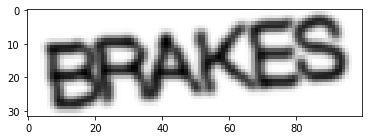

In [0]:
j = 23
xt, yt = train_batch.__getitem__(0)
plt.imshow(xt[j].reshape((32,100)), cmap = 'gray')
print(LEXICON[np.argmax(yt[j])])

SHOE


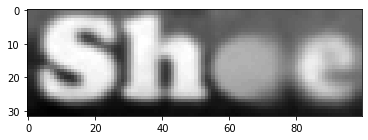

In [0]:
xv, yv = svt_batch.__getitem__(0)
plt.imshow(xv[j].reshape((32,100)), cmap = 'gray')
print(LEXICON[np.argmax(yv[j])])

In [0]:
def get_model(IM_H, IM_W, N_C, num_classes):
  inp = Input(shape = (IM_H, IM_W, N_C))

  x = Conv2D(filters = 64, kernel_size = 5, padding = 'same')(inp)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # x = Dropout(0.2)(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(filters = 128, kernel_size = 5, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # x = Dropout(0.2)(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(filters = 256, kernel_size = 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # x = Dropout(0.2)(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(filters = 512, kernel_size = 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # x = Dropout(0.2)(x)
  # x = MaxPooling2D((2,2))(x)

  x = Conv2D(filters = 512, kernel_size = 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # x = Dropout(0.2)(x)
  x = MaxPooling2D((2,2))(x)

  x = Flatten()(x)

  x = Dense(units = 4000)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.5)(x)

  x = Dense(units = 4000)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.5)(x)

  outputs = Dense(units = num_classes, activation = 'softmax')(x)

  model = Model(inputs= inp, outputs = outputs)
  return model
model = get_model(train_config['IMAGE_H'], train_config['IMAGE_W'], train_config['N_C'], NUM_CLASSES)
model.summary()
# model.load_weights('/content/drive/My Drive/SVT/cnn_model/final_model_150ep.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 100, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 100, 64)       1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 100, 64)       256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 100, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 50, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 50, 128)       512 

In [0]:
model.compile(optimizer = keras.optimizers.sgd(lr = 0.01, decay = 0.01/150), loss = categorical_crossentropy, metrics = ['accuracy'])

In [0]:
checkpoint = ModelCheckpoint('/content/drive/My Drive/SVT/cnn_model/final150ep.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)
history = model.fit_generator(generator = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 150, 
                    verbose          = 1,
                    validation_data  = svt_batch,
                    validation_steps = len(svt_batch),
                    callbacks        = [checkpoint], 
                    max_queue_size   = 3)

In [0]:
checkpoint1 = ModelCheckpoint('/content/drive/My Drive/SVT/cnn_model/final300ep.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)
history = model.fit_generator(generator = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 150, 
                    verbose          = 1,
                    validation_data  = svt_batch,
                    validation_steps = len(svt_batch),
                    callbacks        = [checkpoint1], 
                    max_queue_size   = 3)

In [0]:
# now train on svt data 
newxtrain, newytrain = SVTGen(train_images, LEXICON, svt_config)
svttrain = SVT_2(newxtrain, newytrain, 16)
newxvalid, newyvalid = SVTGen(valid_images,LEXICON, svt_config)  
svtvalid = SVT_2(newxvalid,newyvalid, 16)


In [0]:
model2 = get_model(train_config['IMAGE_H'], train_config['IMAGE_W'], train_config['N_C'], NUM_CLASSES)
model2.load_weights('/content/drive/My Drive/SVT/cnn_model/final300ep.h5')
model2.compile(optimizer = keras.optimizers.sgd(lr = 0.001), loss = categorical_crossentropy, metrics = ['accuracy'])

checkpoint3 = ModelCheckpoint('/content/drive/My Drive/SVT/cnn_model/final_svttrain_v3.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1) 


hist1 = model2.fit_generator(generator = svttrain, 
                    steps_per_epoch  = len(svttrain), 
                    epochs           = 75, 
                    verbose          = 1,
                    validation_data  = svtvalid,
                    validation_steps = len(svtvalid),
                    callbacks        = [checkpoint3], 
                    max_queue_size   = 3)

In [0]:
model3 = load_model('/content/drive/My Drive/SVT/cnn_model/final_svttrain.h5')
model3.evaluate(newxvalid, newyvalid)

136/136 [==============================] - 0s 2ms/step


[4.234180843128877, 0.38235294818878174]